# Sports Car Analysis

## Introduction

This Jupyter notebook aims to analyze a dataset of sports cars to help a company gain deeper insights into their competitive strategy. The company wants to validate their assumptions and uncover hidden market insights related to their competitors. Specifically, they intend to assess how their car models compare to those of their competitors.

To achieve this, we will focus on clustering the dataset of sports cars, which will enable us to understand the distribution of various car features across different models.

### Dataset
- The dataset we will use for this analysis is the [Sports Car Prices Dataset](https://www.kaggle.com/datasets/rkiattisak/sports-car-prices-dataset). It provides valuable information about sports car features and prices.

Let's start by importing the necessary Python libraries for our analysis.

In [632]:
# Data manipulation and analysis
import pandas as pd
import numpy as np

# Data visualization
import matplotlib as mpl
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.feature_selection import VarianceThreshold
from yellowbrick.cluster import SilhouetteVisualizer

## This notebook is divided into five main sections for structured analysis:

1. __Data Preparation__
2. __Initial Clustering__:
   - Silhouette Score Calculation
   - K-Means
   - EM Algorithm
3. __Dimensionality Reduction__
4. __Final Clustering__:
   - K-Means
   - EM Algorithm
5. __Best Clustering Choice__

# Data Preparation

In [633]:
# Load the dataset
cars = pd.read_csv('sport_cars_prices.csv')

# Let's take a look at the first few rows of our dataset to understand its structure.
# Show the first 5 rows to see how does our data look like
cars.head()

,Car Make,Car Model,Year,Engine Size (L),Horsepower,Torque (lb-ft),0-60 MPH Time (seconds),Price (in USD)
0,Porsche,911,2022,3,379,331,4,"101,200"
1,Lamborghini,Huracan,2021,5.2,630,443,2.8,"274,390"
2,Ferrari,488 GTB,2022,3.9,661,561,3,"333,750"
3,Audi,R8,2022,5.2,562,406,3.2,"142,700"
4,McLaren,720S,2021,4,710,568,2.7,"298,000"


In [634]:
# Show further information about the dataset
cars.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1007 entries, 0 to 1006
Data columns (total 8 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   Car Make                 1007 non-null   object
 1   Car Model                1007 non-null   object
 2   Year                     1007 non-null   int64 
 3   Engine Size (L)          997 non-null    object
 4   Horsepower               1007 non-null   object
 5   Torque (lb-ft)           1004 non-null   object
 6   0-60 MPH Time (seconds)  1007 non-null   object
 7   Price (in USD)           1007 non-null   object
dtypes: int64(1), object(7)
memory usage: 63.1+ KB


The dataset consists of 1007 rows and 8 columns, including features like 'Car Make,' 'Year,' and more. We notice that some columns have data type 'object,' which should be converted to numeric types for analysis.

__Data Cleaning and Column Selection__

We need to perform some data cleaning and select relevant columns for our clustering analysis. Specifically:

* Convert numeric columns like 'Engine Size,' 'Horsepower,' 'Torque,' '0-60 MPH Time,' and 'Price' to the appropriate data type.

* Drop columns that are not relevant to clustering, such as 'Car Make,' 'Year,' and 'Model.'

__Handling Missing Values__

The 'cars' dataset has a maximum of 997 non-null values (e.g., 'Engine Size'). Since less than 2% of the data is missing, we will handle missing values by dropping the respective rows later in the analysis.

These initial steps prepare the dataset for further analysis and clustering.

In [635]:
# The 'Price' column represents values in thousands, with commas as separators. We will remove the commas and convert it to a numeric value.
cars['Price (in USD)'] = pd.to_numeric(cars['Price (in USD)'].str.replace(',', ''))

# We will convert several columns to numeric data types while handling non-numeric values by converting them to NaN:
cars['Engine Size (L)'] = pd.to_numeric(cars['Engine Size (L)'], errors='coerce') 
cars['Horsepower'] = pd.to_numeric(cars['Horsepower'], errors='coerce')
cars['Torque (lb-ft)'] = pd.to_numeric(cars['Torque (lb-ft)'], errors='coerce')
cars['0-60 MPH Time (seconds)'] = pd.to_numeric(cars['0-60 MPH Time (seconds)'], errors='coerce')

# We create a new column 'Name + Model' to combine 'Car Make' and 'Car Model' for unique identification.
cars['Name + Model'] = cars['Car Make'] + ' ' + cars['Car Model']

# Set the 'Name + Model' as the index and drop columns that are not relevant to clustering:
cars.set_index('Name + Model', inplace=True)

# Drop the columns containing the text labels, and year because it is not a physical attribute that can influence the data
cars = cars.drop(['Car Make', 'Car Model', 'Year'], axis=1)

To address differences in the scale of values among columns, we'll normalize the data using the Min-Max scaling technique. This will ensure that all values fall between 0 and 1.

In [636]:
# Initialize the MinMaxScaler
scaler = MinMaxScaler()

# Scale the data, so that the values are between 0 and 1
cars_scaled = pd.DataFrame(scaler.fit_transform(cars), columns=cars.columns)

cars_scaled.describe()

,Engine Size (L),Horsepower,Torque (lb-ft),0-60 MPH Time (seconds),Price (in USD)
count,948.000000,998.000000,999.000000,1006.000000,1007.000000
mean,0.523307,0.245368,0.313040,0.364896,0.068992
std,0.166524,0.164911,0.140017,0.165183,0.142671
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.416667,0.150082,0.234411,0.234043,0.009043
50%,0.476190,0.225399,0.293880,0.361702,0.022222
75%,0.619048,0.269379,0.348730,0.468085,0.043478
max,1.000000,1.000000,1.000000,1.000000,1.000000


__Handling Missing Values__

After data conversion, some entries in the 'Engine Size' column became NaN values. We can drop the rows with missing values, as they constitute a small percentage of the dataset.

In [637]:
# Drop the NaN values
cars_scaled.dropna(inplace=True)

cars_scaled.describe()

,Engine Size (L),Horsepower,Torque (lb-ft),0-60 MPH Time (seconds),Price (in USD)
count,946.000000,946.000000,946.000000,946.000000,946.000000
mean,0.523407,0.226193,0.295467,0.380842,0.060891
std,0.165240,0.125600,0.102595,0.153570,0.132597
min,0.178571,0.000000,0.087182,0.063830,0.000000
25%,0.416667,0.150082,0.229792,0.255319,0.008739
50%,0.476190,0.219351,0.291570,0.361702,0.018357
75%,0.619048,0.263332,0.340647,0.468085,0.041502
max,1.000000,0.780099,0.750577,1.000000,1.000000


Now, the dataset is ready for further clustering analysis.

# Silhouette Score Calculation

The clustering Algorithms that are used in this notebook are K-Means and EM (Expectation-Maximization) algorithms. To determine the optimal number of clusters for these algorithms, we calculate the Silhouette Score, which measures the quality of a clustering technique. The Silhouette Score ranges from -1 to 1, and a higher score indicates better cluster separation. The calculation is performed on the scaled data.

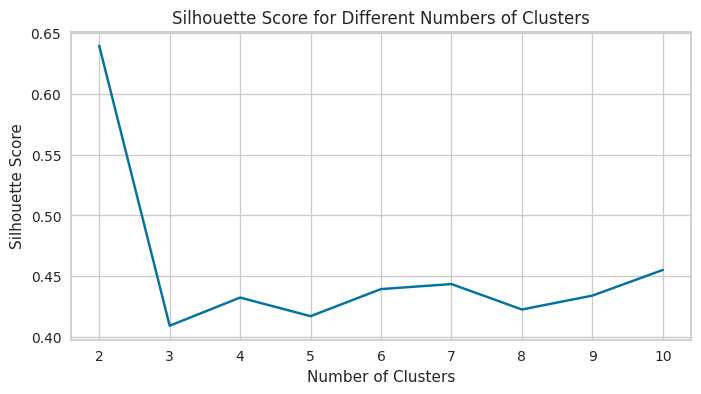

In [638]:
# Function to calculate Silhouette Scores for different numbers of clusters
def silhouette_calc(df):
    silhouettes = []

    for k in range (2, 11):
        kmeans = KMeans(n_clusters=k, n_init=10, random_state=1)
        cluster_assignments = kmeans.fit_predict(df)
        silhouettes.append(silhouette_score(df, cluster_assignments))
    
    return silhouettes

# Calculate the silhouette for the scaled data of cars
silhouettes = silhouette_calc(cars_scaled)

# Plot Silhouette Scores for different numbers of clusters
plt.figure(figsize=(8, 4))
plt.plot(range(2, 11), silhouettes)
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score for Different Numbers of Clusters')
plt.grid(True)
plt.show()

The y-axis shows us the value of the silhouette coefficient and the x-axis shows us the number of clusters that we want to have. The optimal number of clusters is usually the one that has the highest silhouette score. The cluster's silhouette score should ideally be > 0.7. The cluster that has the coefiicient < 0.5 has an unusable structure.

In this case, the optimal number of clusters is 2. The silhouette coefficient for 2 clsuters is apx. 0.64, which is not ideal, but is still OK (> 0.5).

We will try to come up with a better silhouette coefficient using different techniques, but for now we will use 2 clusters.

The silhouette coefficient was calculated for the whole, 5 dimensional (number of columns after preparing dataset) dataset. That is why the clustering algorithms will be applied to the whole dataset. It will be difficult to visualize the data in 5 dimensions, that is why after running the algorithms we will look at some interesting values.

# K-Means

We will now apply the K-Means algorithm to the dataset with 2 clusters, as determined by the Silhouette Score calculation. We will also visualize how many values of clusters have the average or above-average silhouette coefficients.

In [639]:
# Function to plot clusters with centers and visualize silhouette scores
def plot_clusters_with_centers(kmeans, X):

    plt.figure(figsize=(8,8))
    cluster_assignments = kmeans.fit_predict(X)

    visualizer = SilhouetteVisualizer(kmeans, is_fitted=True)

    visualizer.fit(X) #fit the data to the visualizer
    visualizer.finalize()
    print(f'Silhoutte score: {visualizer.silhouette_score_}')
    visualizer.show()

    return cluster_assignments

c:\Users\sayfi\Desktop\Папка для папок\Уни Киль\Uni Projects\Math\mathenv\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\sayfi\Desktop\Папка для папок\Уни Киль\Uni Projects\Math\mathenv\lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(


Silhoutte score: 0.6392663578764872


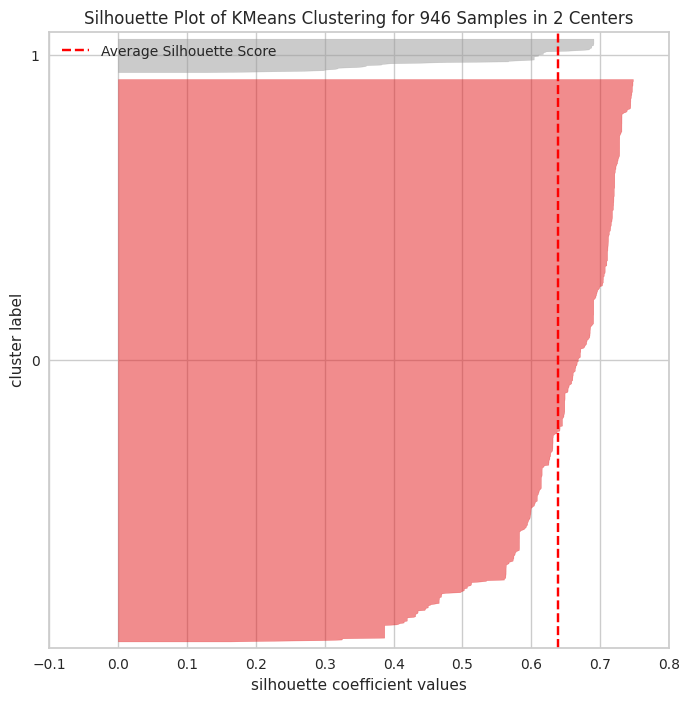

In [640]:
# Initialize the KMeans algorithm with 2 clusters, random state equals 1 for reproducibility
kmeans = KMeans(n_clusters=2, random_state=1)

# Use the function above
k_labels = plot_clusters_with_centers(kmeans, cars_scaled)

From the generated Silhouette Score, we interpret the results:

While this score is not ideal (as it is below 0.7), it is still acceptable (> 0.5). It suggests that the clusters have some level of separation, but there is room for improvement.

This analysis serves as an initial step, and further exploration, perhaps with different techniques or parameters, can be considered to enhance the clustering results.

# Cluster Centers

Let's examine the cluster centers to understand the average representation of each cluster. We'll scale back the dataset to obtain the actual values of the features.

In [641]:
# Inverse transform to get actual values of the features for cluster centers
cluster_centers_actual = scaler.inverse_transform(kmeans.cluster_centers_)

# Display the cluster centers for each feature
pd.DataFrame(cluster_centers_actual, columns=cars_scaled.columns)

,Engine Size (L),Horsepower,Torque (lb-ft),0-60 MPH Time (seconds),Price (in USD)
0,4.272646,552.823991,480.774664,3.655045,1.810874e+05
1,6.444444,1246.925926,1023.388889,2.514815,2.966944e+06


Based on these values the company can have a more or less clear ideaa where their car models belong to.

# Expectation-Maximization (EM) Algorithm

To gain a comprehensive view of clustering and explore potential improvements, we will employ another clustering technique called the EM (Expectation-Maximization) Algorithm. Similar to the K-Means approach, we will use the Silhouette Coefficient to determine the optimal number of clusters, which remains as 2.

In [642]:
# Import GaussianMixture for EM Algorithm
from sklearn.mixture import GaussianMixture

# Separate the features from the target variable
X = cars_scaled.to_numpy()

# Create an instance of GaussianMixture with 2 clusters
gm = GaussianMixture(n_components=2, random_state=1)

# Assign every point to a cluster using the EM Algorithm
cluster_assignments=gm.fit_predict(X)

Now, let's examine the average representatives of the clusters:

In [643]:
# Inverse transform to get actual values of the features for cluster centers
cluster_centers_actual_em = scaler.inverse_transform(gm.means_)

# Display the cluster centers for each feature
pd.DataFrame(cluster_centers_actual_em, columns=cars_scaled.columns)

,Engine Size (L),Horsepower,Torque (lb-ft),0-60 MPH Time (seconds),Price (in USD)
0,4.275061,551.150116,479.718661,3.661710,1.734367e+05
1,6.185877,1200.288263,983.212476,2.533793,2.793484e+06


The average representatives of the clusters generated by the EM Algorithm are now slightly different from the K-Means results. This variation implies that some points in these clusters might be assigned differently in the two clustering algorithms.

The dataset is still in 5 dimensions, making it challenging to visualize the clusters directly.

Given the high dimensionality of the dataset, we will explore dimensionality reduction techniques to gain a more interpretable and visual understanding of the clusters.

# Dimensionality Reduction

### Variance Threshold

One possible technique for dimensionality reduction is the Variance Threshold. It serves as a simple baseline approach to feature selection, removing features whose variance doesn't meet a specified threshold.

In [644]:
# Calculate the variance of different columns
variance_values = cars_scaled.var()

# Display the variance values for each column
print(variance_values)

Engine Size (L)            0.027304
Horsepower                 0.015775
Torque (lb-ft)             0.010526
0-60 MPH Time (seconds)    0.023584
Price (in USD)             0.017582
dtype: float64


To use the Variance Threshold, let's set a threshold of 0.02 and visualize the selected features:

In [645]:
# Initialize the VarianceThreshold
vr = VarianceThreshold(threshold=0.02)

# Fit the VarianceThreshold to the scaled dataset
cars_new = vr.fit_transform(cars_scaled)

# Create a dataframe with the new data
selected_features = vr.get_feature_names_out()
cars_new = pd.DataFrame(cars_new, columns = selected_features)
cars_new.head()

,Engine Size (L),0-60 MPH Time (seconds)
0,0.357143,0.468085
1,0.619048,0.212766
2,0.464286,0.255319
3,0.619048,0.297872
4,0.476190,0.191489


As we can see, the Variance Threshold technique suggests keeping the columns 'Engine Size' and '0-60 MPH Time.'

Let's calculate the Silhouette Score for the selected features and compare it with the full dataset:

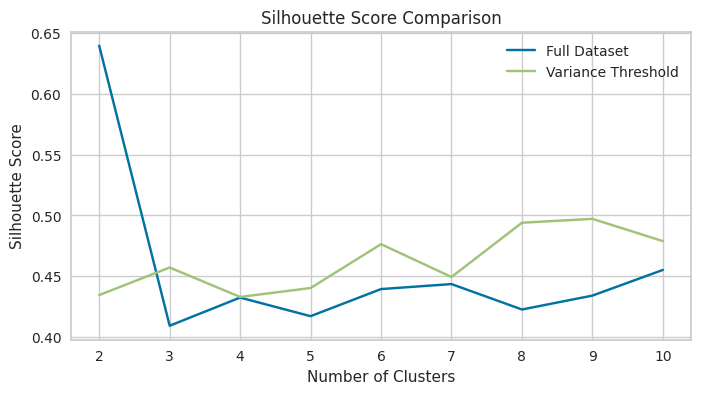

In [646]:
# Calculate the Silhouette Scores for the new dataset with reduced features
silhouette_var = silhouette_calc(cars_new)

# Plot the Silhouette Scores for different numbers of clusters
plt.figure(figsize=(8, 4))
plt.plot(range(2, 11), silhouettes, label="Full Dataset")
plt.plot(range(2, 11), silhouette_var, label="Variance Threshold")
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score Comparison')
plt.legend()
plt.grid(True)
plt.show()

The comparison shows that the Silhouette Score for the dataset with reduced features is even lower than that for the full dataset, particularly at k=2. For all other values of k, the silhouette coefficient is lower than 0.5, indicating that the Variance Threshold technique may not be suitable for this dataset.

### Mutual information-based feature selection

Another technique is Mutual information-based feature selection. This selection technique is based on the concept of mutual information. It measures the reduction in uncertainty for one variable given a known value of the other variable.

With the help of this technique and some domain knowledge, we can select the features that are most relevant to the target variable.

For the company, one of the most important features is the price of the car. That is why we will use the price as the target variable and see which features are most relevant to it.

In [647]:
from sklearn.feature_selection import mutual_info_regression

# Load the data into X and y
X = cars_scaled.drop('Price (in USD)', axis=1)  # Drop the 'Price' column from the DataFrame to get the features
y = cars_scaled['Price (in USD)']  # Select the 'Price' column as the target variable

# Calculate mutual information scores between features and the target variable
mutual_info = mutual_info_regression(X, y)

# Sort the mutual information scores in descending order
sorted_mi = sorted(list(zip(X.columns, mutual_info)), key=lambda x: x[1], reverse=True)

# Select the top k features based on their mutual information scores
k = 2  # Select the top 2 features for better interpretability

selected_features = [f[0] for f in sorted_mi[:k]]
print('Selected features:', selected_features)

Selected features: ['Horsepower', 'Torque (lb-ft)']


As we can see, the technique suggested to take the columns Horsepower and Torque as the most relevant features to the price.

We will run them both together and separately for the Price feature.

Now, let's calculate and compare the Silhouette Scores for the selected features and the full dataset:

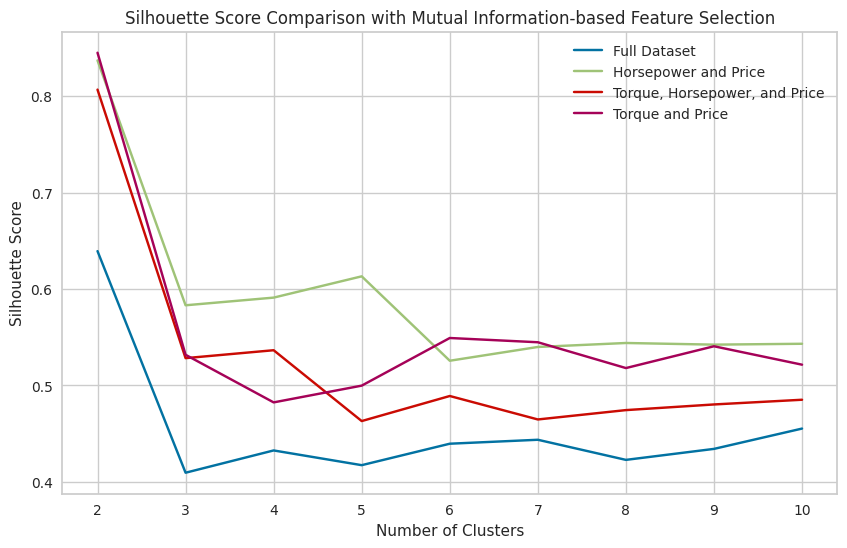

In [648]:
# Calculate the Silhouette Scores for different numbers of clusters
silhouettes_HP = silhouette_calc(cars_scaled[['Horsepower', 'Price (in USD)']])
silhouettes_THP = silhouette_calc(cars_scaled[['Torque (lb-ft)', 'Horsepower', 'Price (in USD)']])
silhouettes_TP = silhouette_calc(cars_scaled[['Torque (lb-ft)', 'Price (in USD)']])

# Visualize the Silhouette Scores
plt.figure(figsize=(10, 6))
plt.plot(range(2, 11), silhouettes, label="Full Dataset")
plt.plot(range(2, 11), silhouettes_HP, label="Horsepower and Price")
plt.plot(range(2, 11), silhouettes_THP, label="Torque, Horsepower, and Price")
plt.plot(range(2, 11), silhouettes_TP, label="Torque and Price")
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score Comparison with Mutual Information-based Feature Selection')
plt.legend()
plt.grid(True)
plt.show()

The adjusted datasets with selected features (Horsepower and Price, Torque, Horsepower, and Price, Torque and Price) exhibit higher Silhouette Scores compared to the full dataset. This indicates improved clustering quality. Although we tested with three and more clusters, the Silhouette Score is highest for two clusters, suggesting that it might be the optimal choice.

### Principal Component Analysis (PCA)

Another dimensionality reduction technique is Principal Component Analysis (PCA). It transforms correlated variables into linearly uncorrelated variables called principal components.

In [649]:
from sklearn.decomposition import PCA

# Initialize PCA with 2 components
pca = PCA()

# Perform PCA transformation
pca_transformed = pca.fit_transform(cars_scaled)
df_pca = pd.DataFrame(pca_transformed)
df_pca.head()

,0,1,2,3,4
0,-0.236279,-0.064340,0.026779,0.036873,0.001434
1,0.116919,-0.002437,-0.137445,0.079402,-0.026231
2,0.059573,-0.118081,-0.062539,-0.008291,0.003140
3,0.039874,0.051164,-0.108219,0.070584,-0.024355
4,0.107457,-0.142517,-0.106918,-0.004635,-0.008387


Let's examine the covariance matrix, explained variance ratio, and visualize the data in the PCA space:

In [650]:
# Display covariance matrix
cars_scaled.cov()

,Engine Size (L),Horsepower,Torque (lb-ft),0-60 MPH Time (seconds),Price (in USD)
Engine Size (L),0.027304,0.012133,0.010245,-0.009147,0.008686
Horsepower,0.012133,0.015775,0.011852,-0.014266,0.013126
Torque (lb-ft),0.010245,0.011852,0.010526,-0.010579,0.010011
0-60 MPH Time (seconds),-0.009147,-0.014266,-0.010579,0.023584,-0.009685
Price (in USD),0.008686,0.013126,0.010011,-0.009685,0.017582


In [651]:
# Display the covariance matrix of the PCA-transformed data
df_pca.cov().round(2)

,0,1,2,3,4
0,0.06,0.00,0.00,0.0,-0.0
1,0.00,0.02,-0.00,0.0,0.0
2,0.00,-0.00,0.01,-0.0,0.0
3,0.00,0.00,-0.00,0.0,0.0
4,-0.00,0.00,0.00,0.0,0.0


In [652]:
# Explained variance ratio
expl_var = pca.explained_variance_ratio_
print(expl_var)

[0.66921611 0.18091134 0.11228137 0.0281228  0.00946837]


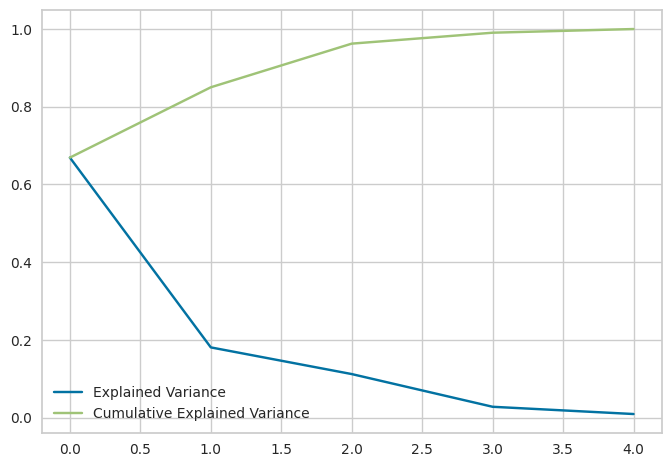

In [653]:
# Plot explained variance and cumulative explained variance
plt.plot(expl_var, label='Explained Variance')
plt.plot(np.add.accumulate(expl_var), label='Cumulative Explained Variance')
plt.legend()

Now, let's use a technique to determine the optimal number of principal components:

In [654]:
from pca import pca

# Initialize PCA model for selecting optimal number of components
model = pca(n_components=2)

# Fit transform
results = model.fit_transform(cars_scaled)

[pca] >Extracting column labels from dataframe.
[pca] >Extracting row labels from dataframe.
[pca] >The PCA reduction is performed on the [5] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Outlier detection using Hotelling T2 test with alpha=[0.05] and n_components=[2]
[pca] >Multiple test correction applied for Hotelling T2 test: [fdr_bh]
[pca] >Outlier detection using SPE/DmodX with n_std=[3]


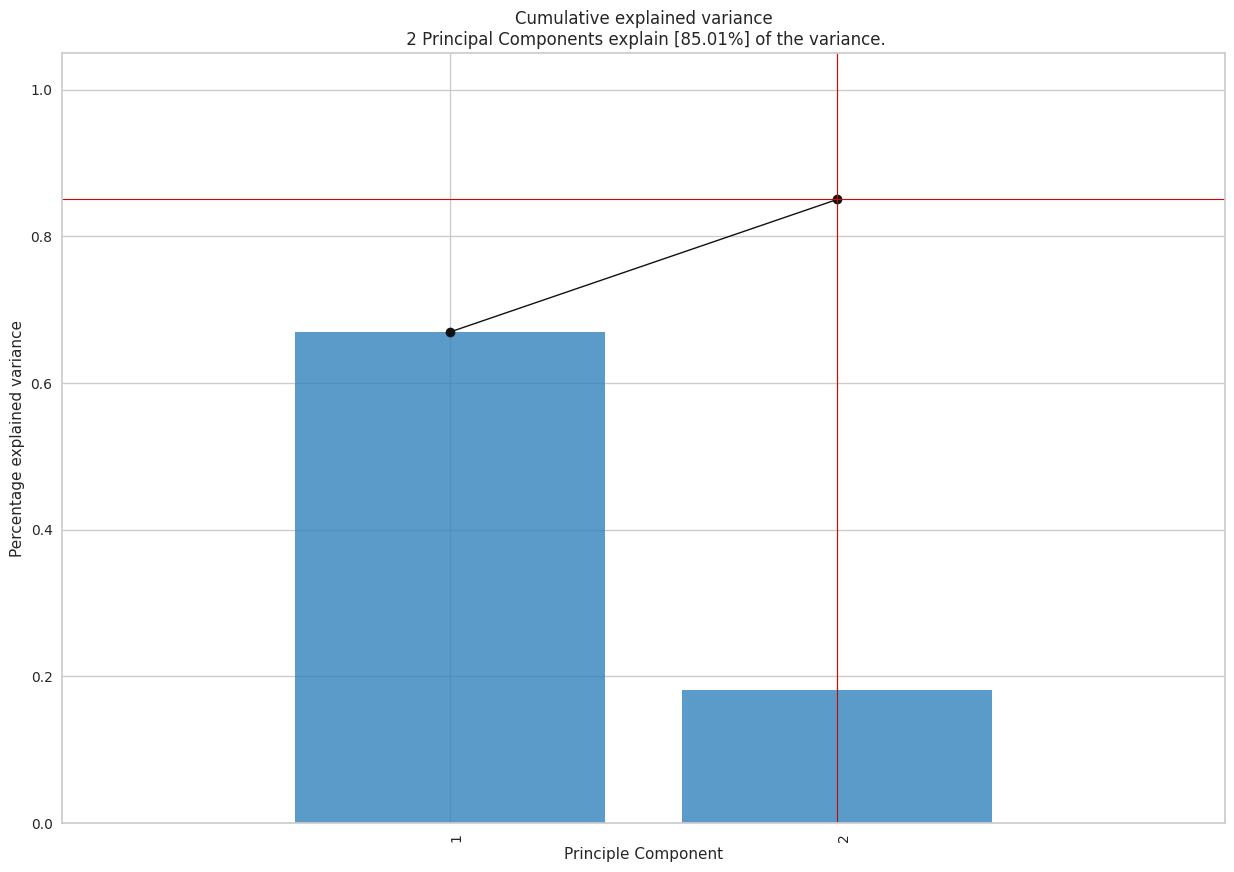

<Figure size 800x550 with 0 Axes>

In [655]:
# explained variance plot
fig, ax = model.plot()

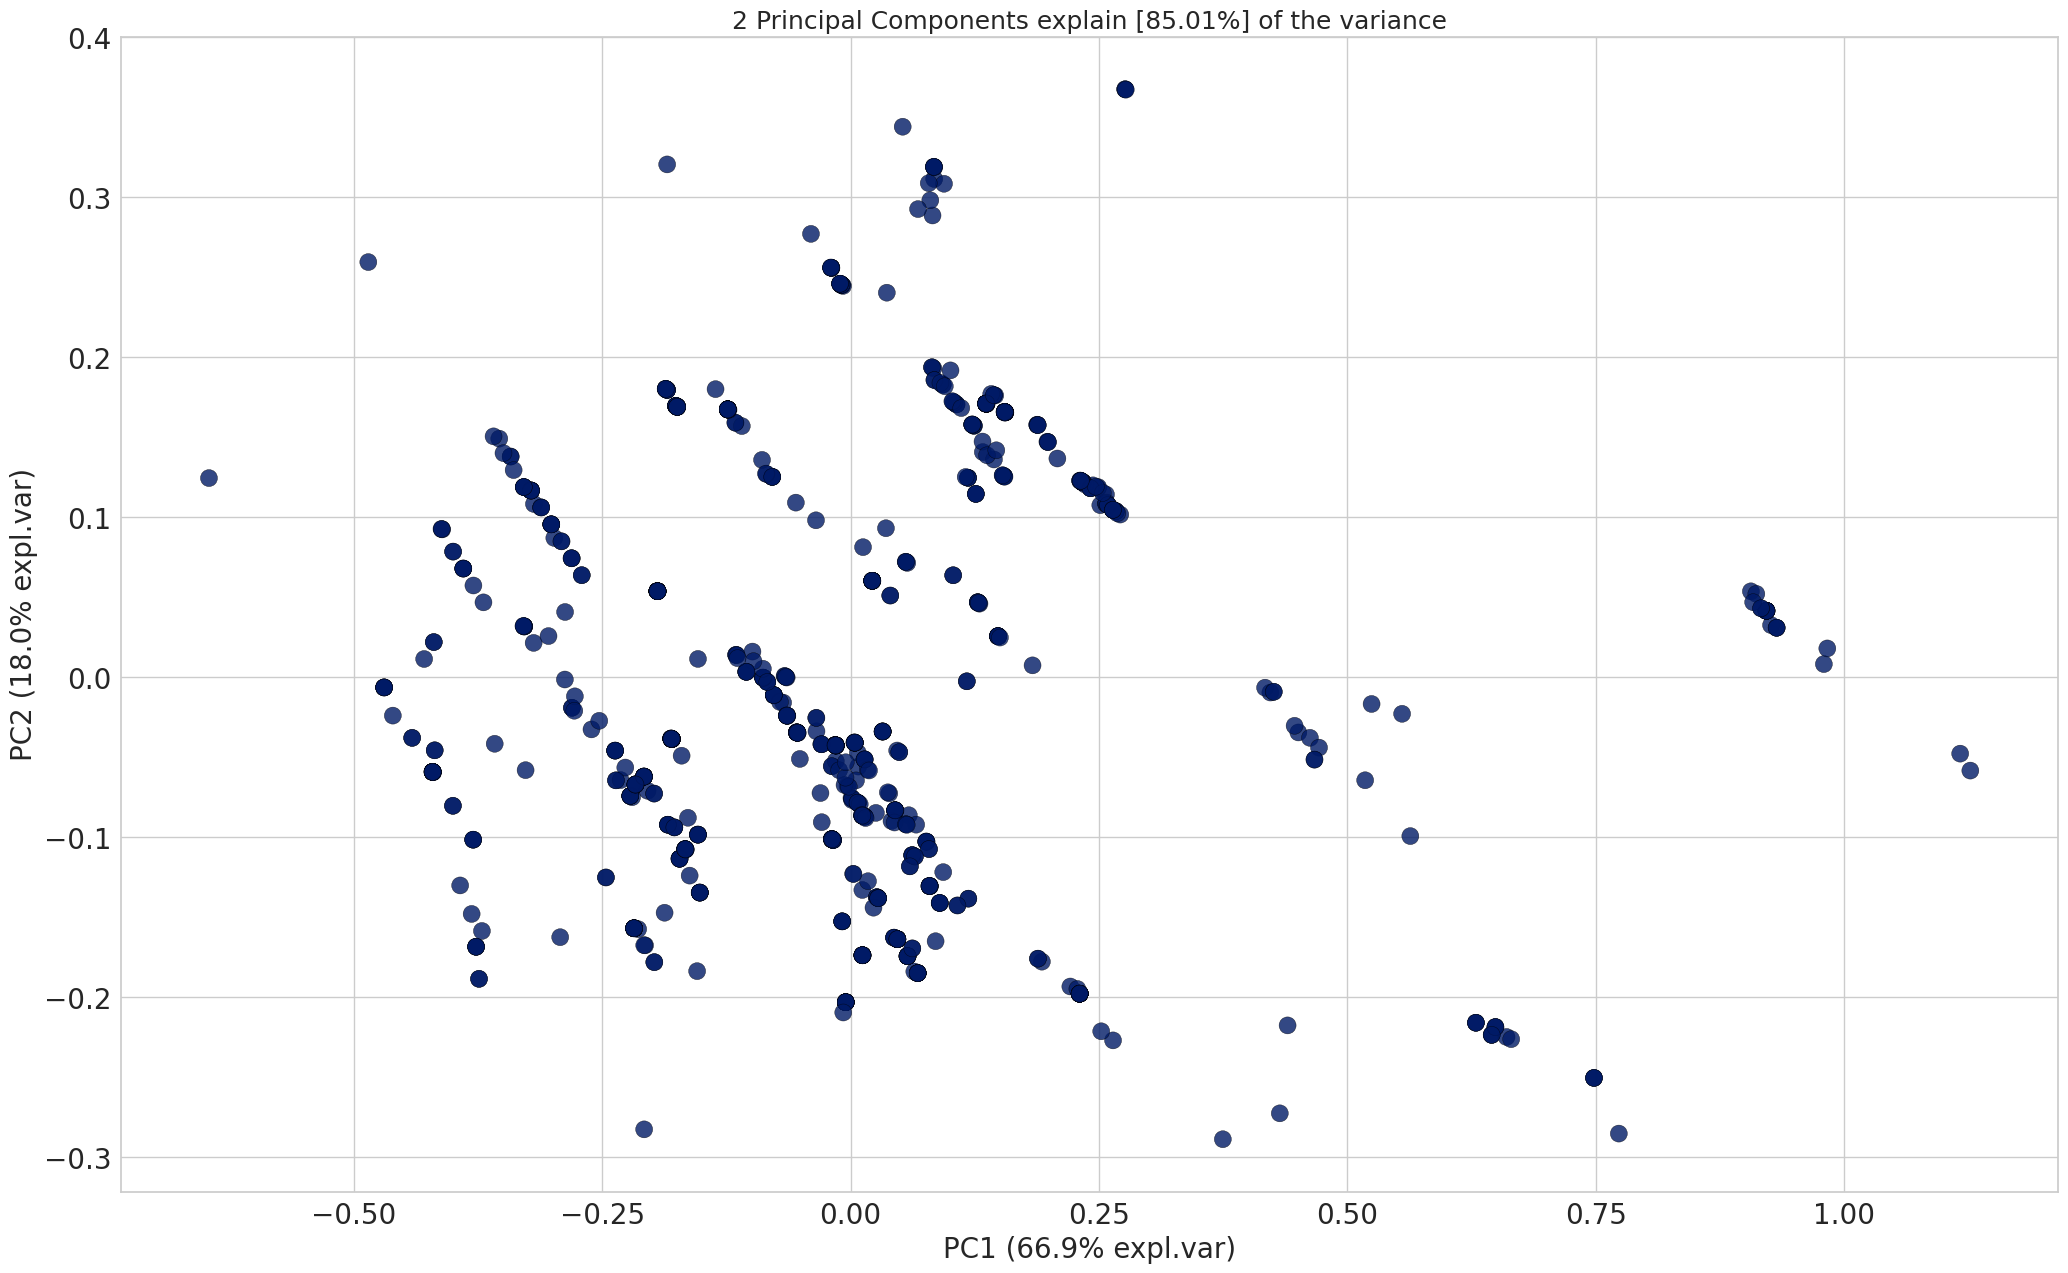

In [656]:
# Scatter plot of the first two principal components
fig, ax = model.scatter(legend=False, PC=[0, 1])

[pca] >Plot PC1 vs PC2 with loadings.


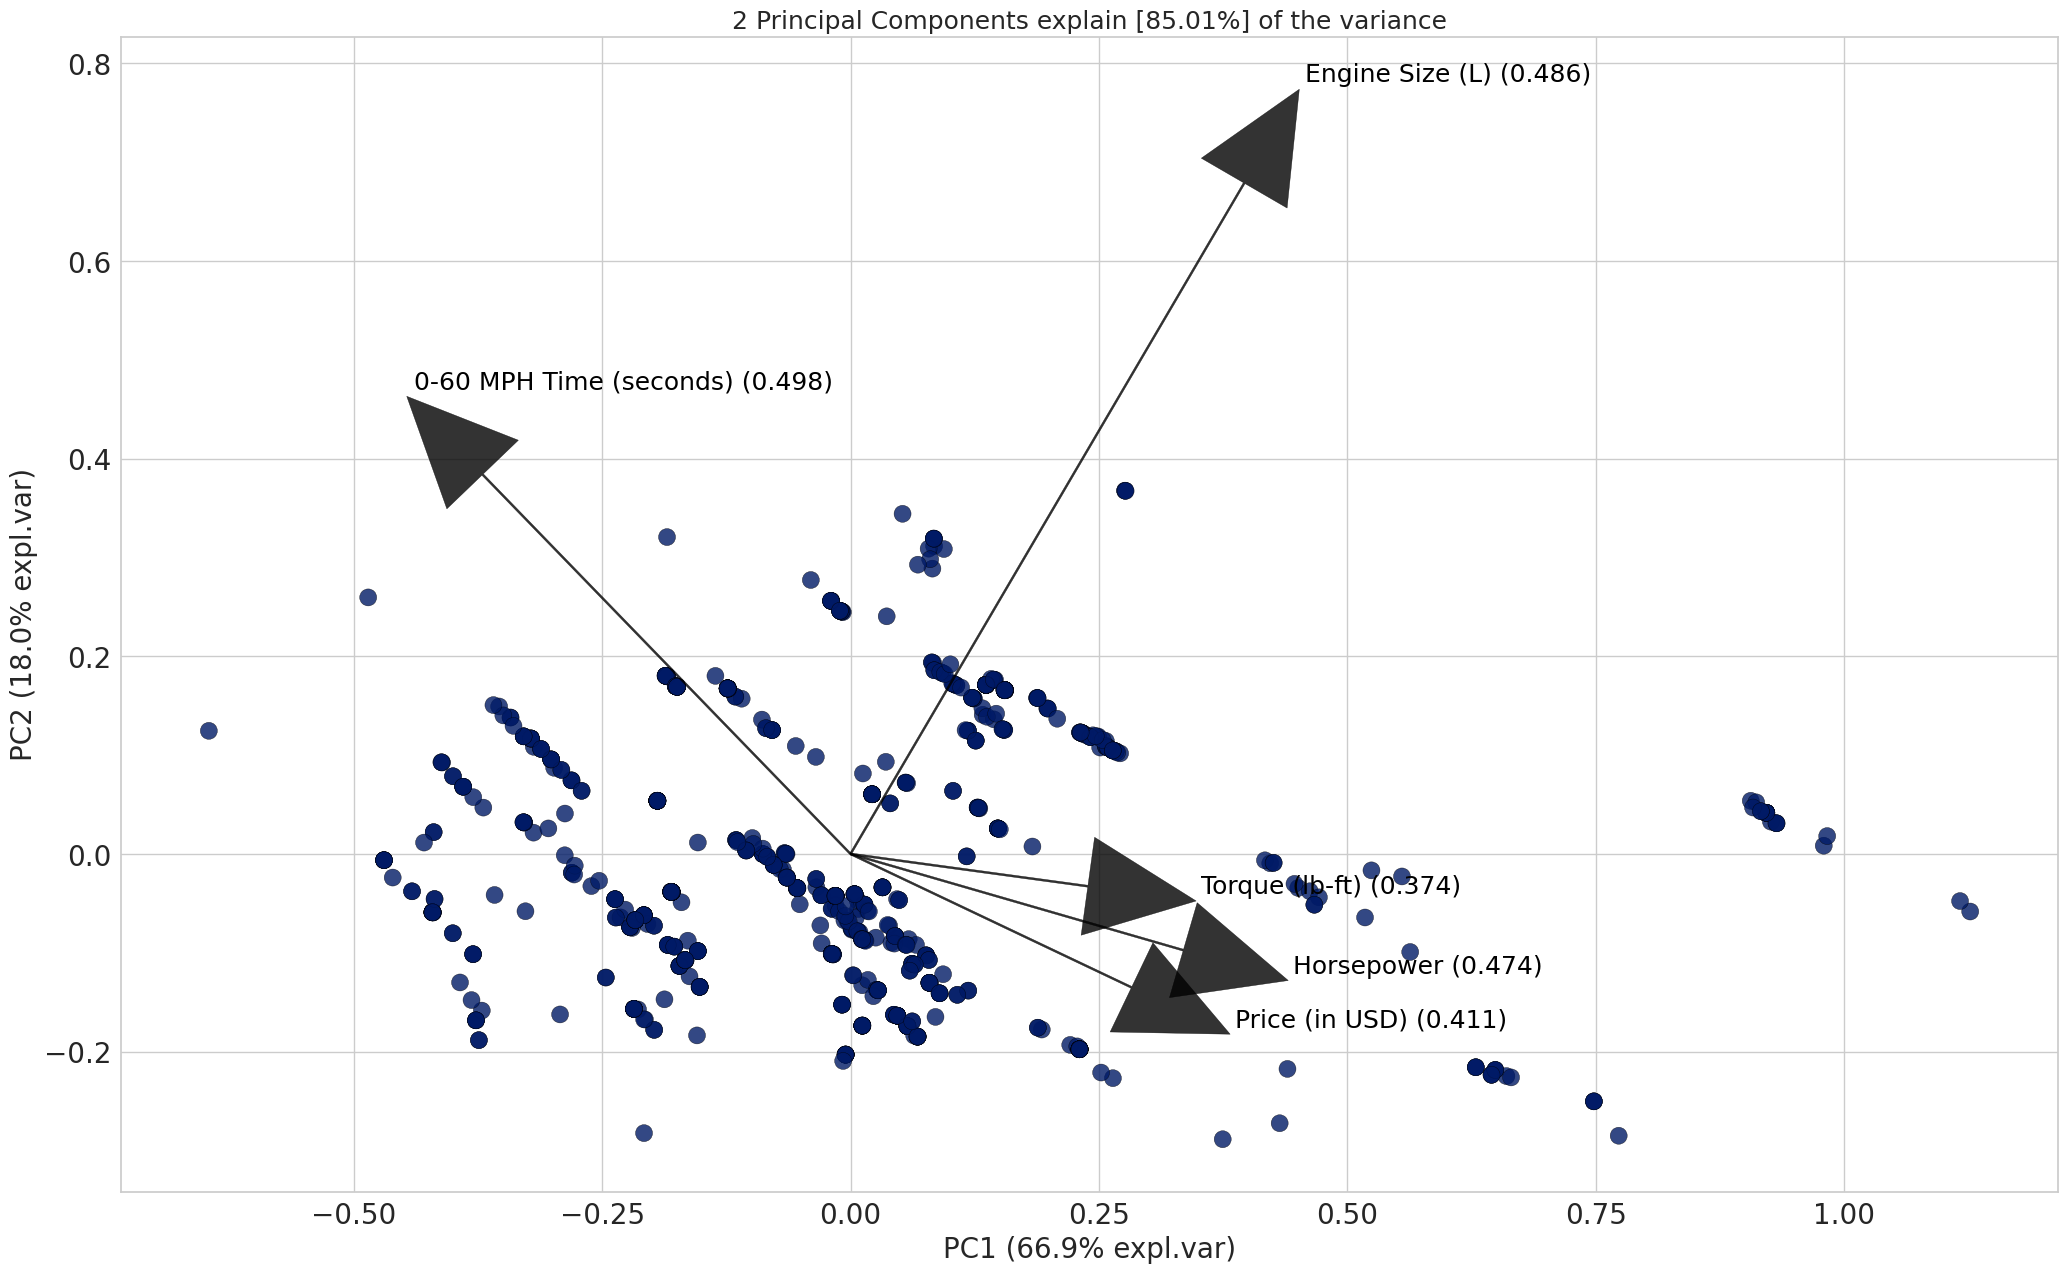

In [657]:
# biplot with number of original features (plot data and loadings)
fig, ax = model.biplot(n_feat=10, legend=False)

In [658]:
# Fit PCA to the original dataset
dp = cars.dropna().copy()
df = cars_scaled.set_index(dp.index)
model.fit_transform(df)
L = model.results['PC']

[pca] >Cleaning previous fitted model results..
[pca] >Extracting column labels from dataframe.
[pca] >Extracting row labels from dataframe.
[pca] >The PCA reduction is performed on the [5] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Outlier detection using Hotelling T2 test with alpha=[0.05] and n_components=[2]
[pca] >Multiple test correction applied for Hotelling T2 test: [fdr_bh]
[pca] >Outlier detection using SPE/DmodX with n_std=[3]


Now, let's rerun our previous clustering algorithms with the PCA-transformed data to determine the most effective technique.

# K-Means of PCA

In [659]:
# The function takes a dataframe, kmeans algorithm, cluster assignments of that algoriithm and visualizes the clusters
def print_clustering(X, kmeans, cluster_assignments):
    plt.figure(figsize=(10, 10))

    for i in np.unique(cluster_assignments):
        X_sub=X[cluster_assignments==i, :]
        plt.scatter(X_sub[:, 0], X_sub[:, 1], label=i)
    
    plt.scatter(
        kmeans.cluster_centers_[:, 0], 
        kmeans.cluster_centers_[:, 1],
        s=350, marker='*', c='crimson', edgecolor='black'
    )

    plt.legend()

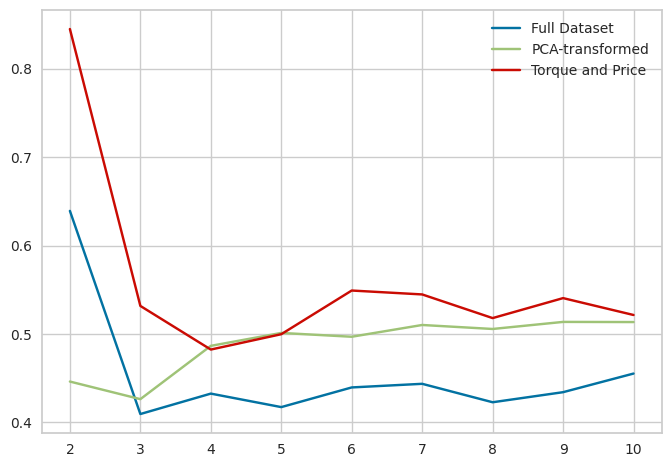

In [660]:
# Calculate Silhouette Scores for K-Means on PCA-transformed data
silhouettes_pca = silhouette_calc(L.to_numpy())

# Plot Silhouette Scores for comparison
plt.plot(range(2, 11), silhouettes, label="Full Dataset")
plt.plot(range(2, 11), silhouettes_pca, label="PCA-transformed")
plt.plot(range(2, 11), silhouettes_TP, label="Torque and Price")
plt.legend()
plt.show()

The Silhouette Scores comparison reveals that the clustering quality is still highest when considering the 'Torque and Price' feature. However, the PCA-transformed data performs better than the full dataset. The visualization of clustering results on the PCA-transformed data provides insights into the structure of the identified clusters.

c:\Users\sayfi\Desktop\Папка для папок\Уни Киль\Uni Projects\Math\mathenv\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


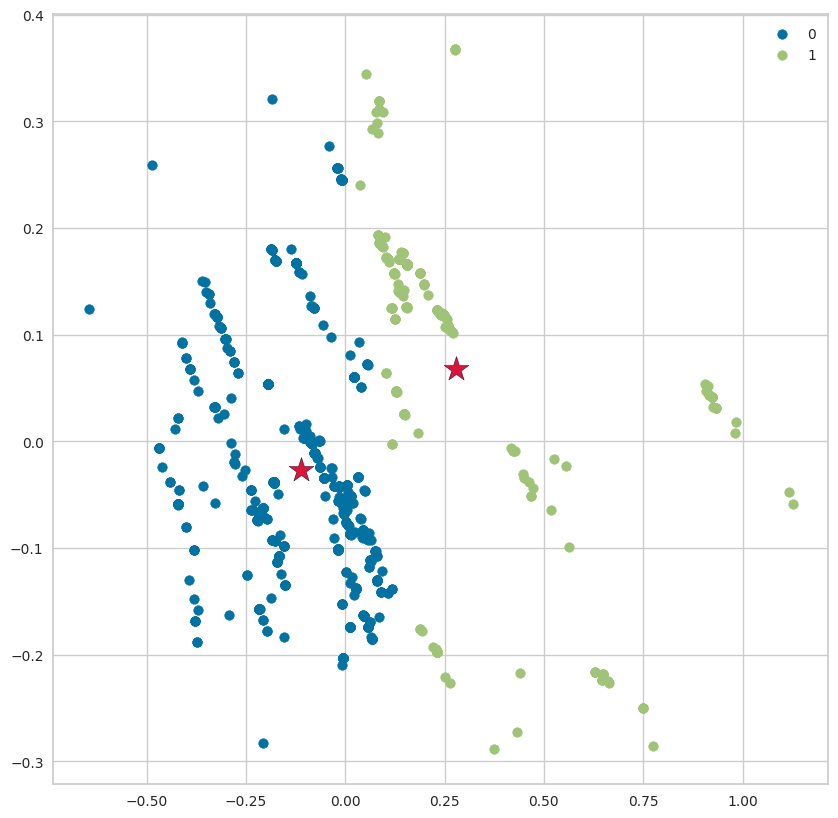

In [661]:
# Fit K-Means on PCA-transformed data
cluster_assignments_pca = kmeans.fit_predict(L)

# Visualize clustering results
print_clustering(L.to_numpy(), kmeans, cluster_assignments_pca)

# EM Algorithm of PCA

In [662]:
def create_ellipse(gmm, ax, n, v0, v1, angle, color, alpha, stretch):
    ell = mpl.patches.Ellipse(
        gmm.means_[n, :2], stretch*v0, stretch*v1, 180 + angle, color=color
    )
    ell.set_clip_box(ax.bbox)
    ell.set_alpha(alpha)
    ax.add_artist(ell)


def make_ellipses(gmm, ax):
    for n, color in enumerate(colors):
        if gmm.covariance_type == "full":
            covariances = gmm.covariances_[n][:2, :2]
        elif gmm.covariance_type == "tied":
            covariances = gmm.covariances_[:2, :2]
        elif gmm.covariance_type == "diag":
            covariances = np.diag(gmm.covariances_[n][:2])
        elif gmm.covariance_type == "spherical":
            covariances = np.eye(gmm.means_.shape[1]) * gmm.covariances_[n]
        v, w = np.linalg.eigh(covariances)
        u = w[0] / np.linalg.norm(w[0])
        angle = np.arctan2(u[1], u[0])
        angle = 180 * angle / np.pi  # convert to degrees
        v = 2.0 * np.sqrt(2.0) * np.sqrt(v)

        create_ellipse(gmm, ax, n, v[0], v[1], angle, color, 0.5, 1)
        create_ellipse(gmm, ax, n, v[0], v[1], angle, color, 0.2, 2)
        create_ellipse(gmm, ax, n, v[0], v[1], angle, color, 0.1, 3)
        ax.set_aspect("equal", "datalim")

In [663]:
# Fit EM Algorithm on PCA-transformed data
X = L.to_numpy()
c_a = gm.fit_predict(X)

# Visualize clustering results with uncertainty
colors = ['darkorange', 'darkmagenta']
em_probs = gm.predict_proba(X)
uncertain_indexes = np.max(em_probs, axis=1) < 0.8

C:\Users\sayfi\AppData\Local\Temp\ipykernel_5652\870935678.py:2: MatplotlibDeprecationWarning: Passing the angle parameter of __init__() positionally is deprecated since Matplotlib 3.6; the parameter will become keyword-only two minor releases later.
  ell = mpl.patches.Ellipse(


<Figure size 800x800 with 0 Axes>

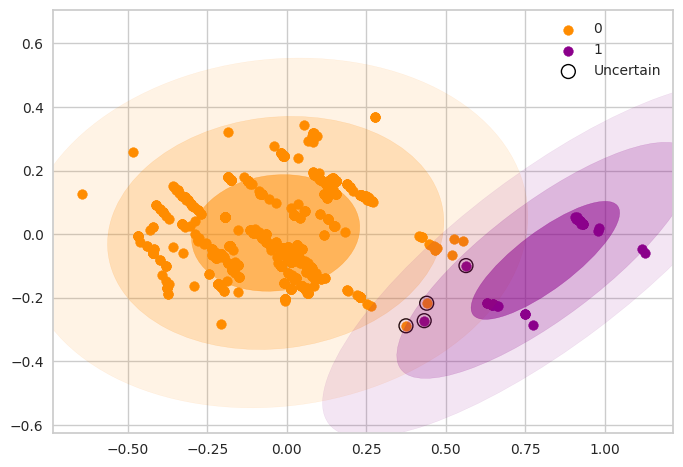

In [664]:
fig = plt.figure(figsize=(8, 8))
fig, ax = plt.subplots()

# Plot points with certain assignments
for i in range(0, len(np.unique(c_a))):
    X_sub = X[c_a == i, :]
    plt.scatter(X_sub[:, 0], X_sub[:, 1], c=colors[i], label=i)

# Plot uncertain points
X_uncertain = X[uncertain_indexes]
plt.scatter(
    X_uncertain[:, 0],
    X_uncertain[:, 1],
    label="Uncertain",
    s=100,
    linewidth=1,
    facecolors='none',
    edgecolors='black'
)

make_ellipses(gm, ax)
plt.legend()

The visualization provides insights into the clustering results obtained by the EM Algorithm on PCA-transformed data. The ellipses represent the clusters, and uncertain points are highlighted separately. This analysis helps in understanding the structure and uncertainty in the identified clusters.

When comparing the results of K-Means and EM Algorithm, notable differences emerge. EM Algorithm identified the second cluster center more towards the right side on the x-axis and slightly lower on the y-axis compared to K-Means. While K-Means distributed points more evenly between clusters, EM Algorithm favored the first cluster, with the second cluster containing fewer points, including uncertain ones.

# Best Clustering Choice

After careful analysis and considering domain knowledge, the preferred clustering approach for our dataset is Mutual information-based feature selection. This technique selects features most relevant to the price of the car, a crucial factor for our company. Among the clustering algorithms evaluated, K-Means stands out as the best choice. It not only provides a clear separation of clusters based on selected features such as 'Horsepower' and 'Torque'—which are deemed most influential on car prices—but also offers interpretability and ease of understanding for strategic decision-making.

## K-Means of Mutual information-based feature selection

Now let's visualize the clusters since we have only 2 features.

Since the K-Means algorithm with the same configuration is reused, there's no need to redefine it.

c:\Users\sayfi\Desktop\Папка для папок\Уни Киль\Uni Projects\Math\mathenv\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


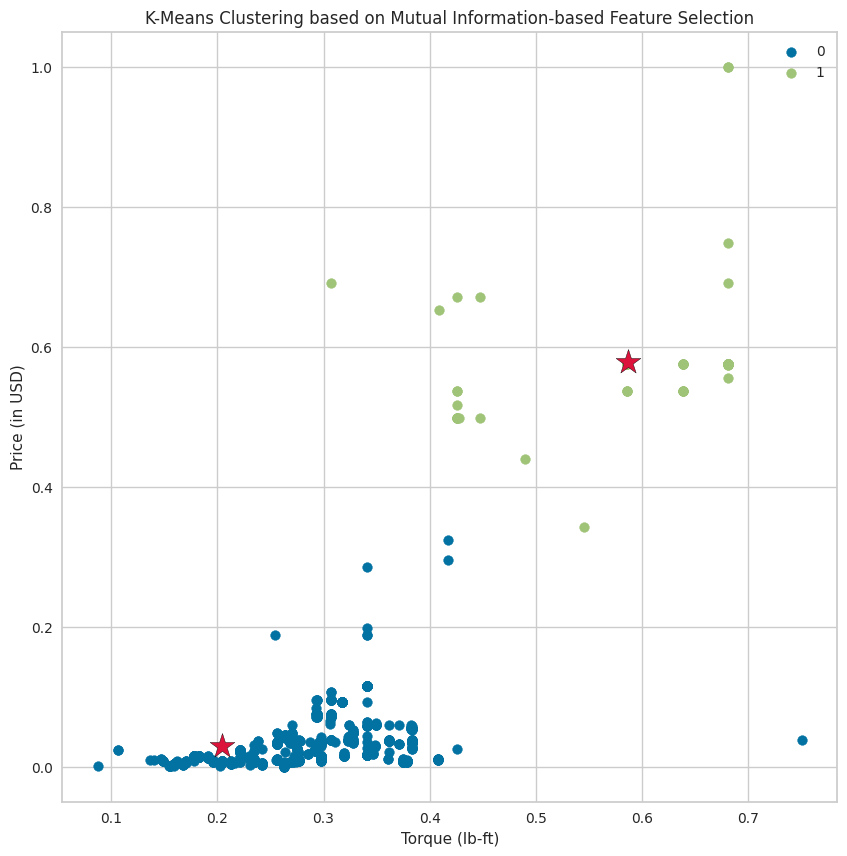

In [665]:
X = cars_scaled[['Torque (lb-ft)', 'Price (in USD)']].to_numpy()

# Fit K-Means on selected features
cluster_assignments = kmeans.fit_predict(cars_scaled[['Horsepower', 'Price (in USD)']])

# Visualize clustering results
print_clustering(X, kmeans, cluster_assignments)
plt.ylabel('Price (in USD)')
plt.xlabel('Torque (lb-ft)')
plt.title('K-Means Clustering based on Mutual Information-based Feature Selection')
plt.show()

## Interpretation

The visualization clearly shows two distinct clusters. The points in the first cluster ('0') are closely grouped, indicating a strong structure. On the other hand, points in the second cluster ('1') are more spread out, suggesting a weaker cluster structure. Cars belonging to the first cluster generally have lower prices compared to those in the second cluster, which aligns with the lower Torque levels in the first cluster. However, it's interesting to note that the car with the highest Torque value falls into the first cluster. Further investigation into additional characteristics may help explain this anomaly. This visualization, with its strong correlation and silhouette coefficient, can guide the company in refining pricing strategies, marketing efforts, and understanding the popularity of different car models.

# Future Work

__1. Feature Engineering:__

* Explore additional features that could have an impact on car prices and cluster formation. For example, consider including features related to fuel efficiency, safety ratings, or advanced technological features.

__2. Advanced Clustering Techniques:__

* Experiment with advanced clustering techniques such as hierarchical clustering, DBSCAN, or agglomerative clustering. Compare their performance with the K-Means and EM algorithms to identify the most suitable method for the dataset.

__3. Ensemble Clustering:__

* Implement ensemble clustering methods that combine the results of multiple clustering algorithms. This could potentially lead to more robust and accurate cluster assignments.

__4. Outlier Detection:__

* Investigate and handle outliers more systematically. Outliers might provide valuable insights into specific car models or market segments that deviate significantly from the general trend.

__5. Temporal Analysis:__

* If the dataset includes a temporal component, analyze how car prices and features have evolved over time. This could uncover trends in the market and help the company stay competitive.

__6. Customer Segmentation:__

* Perform customer segmentation based on the identified clusters. Understand the demographics and preferences of customers associated with each cluster. This information can guide targeted marketing strategies.

__7. Predictive Modeling:__

* Build predictive models to estimate car prices based on the identified features. This could involve regression analysis or machine learning models to provide more accurate pricing predictions.

__8. External Data Integration:__

* Integrate external datasets that provide additional information about market trends, economic indicators, or consumer preferences. This can enhance the richness of the analysis and provide a broader context.

__9. Interactive Dashboards:__

* Create interactive dashboards using tools like Plotly or Tableau. This will allow stakeholders to explore the clustering results, filter data based on different criteria, and gain more dynamic insights.

__10. Feedback Loop:__

* Establish a feedback loop with the company's marketing and product development teams. Regularly update the clustering analysis based on new data and gather feedback to continuously refine and improve the models.